<a href="https://colab.research.google.com/github/si-mong/AI_lab/blob/main/AI_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##개요: text-to-speech pipeline
1. 텍스트 전처리
먼저, 입력 텍스트는 기호 목록으로 인코딩된다. 이 튜토리얼에서는 기호로 영어 문자와 음소를 사용한다.

2. 스펙트로그램 생성
인코딩된 텍스트로부터 스펙트로그램이 생성된다. 이를 위해 Tacotron2 모델을 사용한다.

3. 시간 영역 변환
마지막 단계는 스펙트로그램을 파형(waveform)으로 변환하는 것이다. 스펙트로그램에서 음성을 생성하는 과정은 보코더(Vocoder)라고도 불린다. 이 튜토리얼에서는 WaveRNN, GriffinLim, 그리고 Nvidia의 WaveGlow라는 세 가지 다른 보코더가 사용된다.
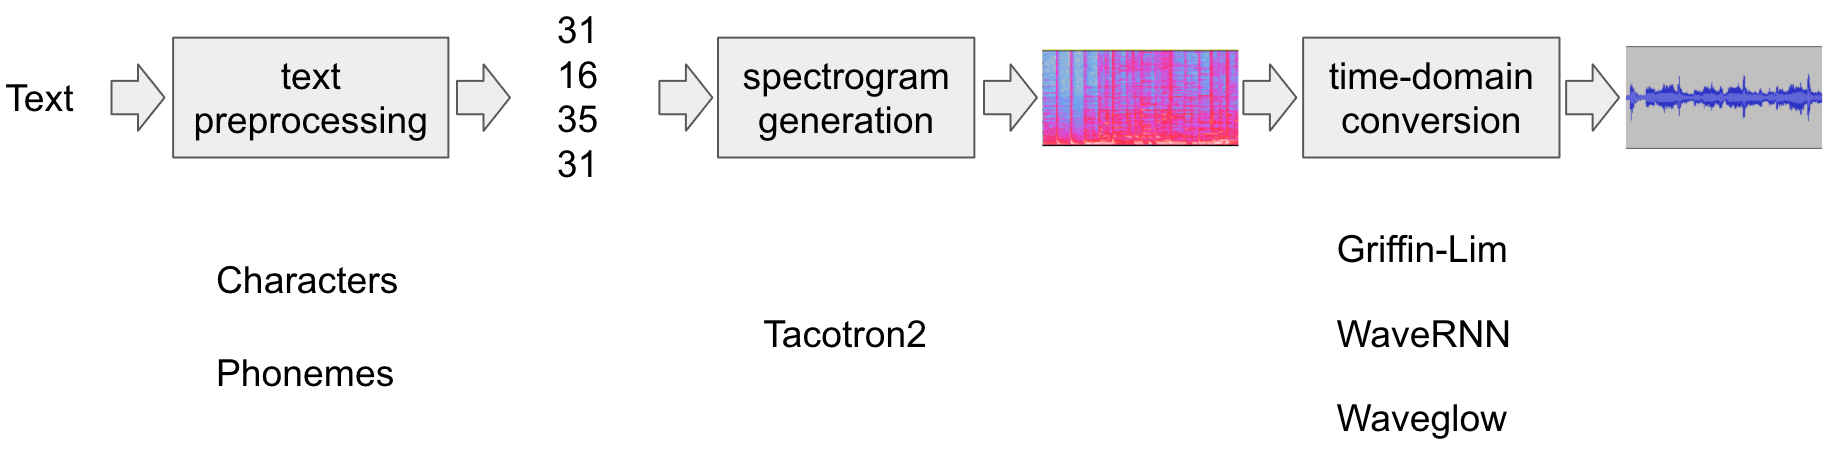

In [ ]:
#2025-10-02
#Text-to-speech
#2023078086 최은재

In [1]:
!pip3 install deep_phonemizer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33357 sha256=f39ee61a6834a22f35408622761e44ec277495a06e9c8387f635916c55aa1e25
  Stored in directory: /root/.cache/pip/wheels/b9/d7/45/f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep_phonemizer


In [2]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cpu
2.8.0+cpu
cpu


In [3]:
import IPython
import matplotlib.pyplot as plt

##Text Processing
###문자 기반 인코딩
사전 훈련된 Tacotron2 모델은 특정 기호 테이블 세트를 예상하기 때문에 torchaudio 동일한 기능을 사용할 수 있다. (이해를 위해 수동으로 구현).

- 먼저, _-!\'(),.:;?abcdefghijklmnopqrstuvwxyz 기호 집합을 정의한다.
- 그 다음, 입력 텍스트의 각 문자를 표에 있는 해당 기호의 인덱스로 매핑한다.
- 표에 없는 기호는 무시된다.

In [4]:
text = "Hello, my name is eunjae. I'm studying software engineering, and I really enjoy my AI class!"

In [5]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


#text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 6, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 16, 32, 25, 21, 12, 16, 7, 11, 20, 3, 24, 11, 30, 31, 32, 15, 36, 20, 25, 18, 11, 30, 26, 17, 31, 34, 12, 29, 16, 11, 16, 25, 18, 20, 25, 16, 16, 29, 20, 25, 18, 6, 11, 12, 25, 15, 11, 20, 11, 29, 16, 12, 23, 23, 36, 11, 16, 25, 21, 26, 36, 11, 24, 36, 11, 12, 20, 11, 14, 23, 12, 30, 30, 2]


###Tacotron2의 기호테이블과 인덱스
tacotron2에서는 특정 글자(기호)들을 특정 숫자(인덱스)와 짝지어 학습한다. 예로 'a'는 10, 'b'는 11등 미리 약속된 **기호 테이블**이 존재한다.
- get_text_processor()을 통해서 모델에 포함된 텍스트 번역기(기호 테이블)을 가져온다.
- 가져온 테이블에 "Hello world" 등의 문장을 넣는다.
- 번역기는 문장의 각 글자를 기호 테이블에서 찾아 해당하는 숫자(인덱스)로 변환한다.
- 테이블에 없는 글자(예: 대문자 'H'는 소문자로 처리)는 규칙에 맞게 처리하고, 없는 기호는 무시한다.

In [6]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

#text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26,  6, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11,
         16, 32, 25, 21, 12, 16,  7, 11, 20,  3, 24, 11, 30, 31, 32, 15, 36, 20,
         25, 18, 11, 30, 26, 17, 31, 34, 12, 29, 16, 11, 16, 25, 18, 20, 25, 16,
         16, 29, 20, 25, 18,  6, 11, 12, 25, 15, 11, 20, 11, 29, 16, 12, 23, 23,
         36, 11, 16, 25, 21, 26, 36, 11, 24, 36, 11, 12, 20, 11, 14, 23, 12, 30,
         30,  2]])
tensor([92], dtype=torch.int32)


In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ',', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'e', 'u', 'n', 'j', 'a', 'e', '.', ' ', 'i', "'", 'm', ' ', 's', 't', 'u', 'd', 'y', 'i', 'n', 'g', ' ', 's', 'o', 'f', 't', 'w', 'a', 'r', 'e', ' ', 'e', 'n', 'g', 'i', 'n', 'e', 'e', 'r', 'i', 'n', 'g', ',', ' ', 'a', 'n', 'd', ' ', 'i', ' ', 'r', 'e', 'a', 'l', 'l', 'y', ' ', 'e', 'n', 'j', 'o', 'y', ' ', 'm', 'y', ' ', 'a', 'i', ' ', 'c', 'l', 'a', 's', 's', '!']


---
##Phoneme-based encoding(음소기반인코딩)
##음소
- **음소:** 의미를 구분하는 가장 작은 소리의 단위 (발음기호)
- 예시: cat
  - 글자(Grapheme): c, a, t (3개)
  - 음소(pheneme): /k/, /æ/, /t/ (3개의 소리)
- 글자 'c'는 /k/ 소리가 나기도 하고 /s/ 소리가 나기도 하지만, 음소 /k/는 언제나 'ㅋ' 소리를 낸다. 이렇게 소리를 기준으로 하면 혼동의 여지가 사라진다.

### 음소 기반 인코딩의 과정
음소 기반 인코딩은 2단계로 이뤄진다.
1. 텍스트 -> 음소로 변환(G2P)
  - 먼저 "cat"이라는 텍스트를 **G2P(Grapheme-to-Phoneme) 모델**이라는 '발음 번역기'에 삽입한다.
  - G2P모델은 이 텍스트를 발음 기호의 나열인 /kæt/로 변환해 준다.
  
2. 음소 -> 숫자로 변환(인코딩)
  - 이제 명확해진 발음기호 /k/, /æ/, /t/를 각각 약속된 숫자 [25], [3], [52] 등으로 바꾼다.  

  이렇게 변환된 숫자 목록을 AI(TTS 모델)에게 전달하면, AI는 더 이상 발음을 추측할 필요 없이 주어진 소리 정보에만 집중해서 훨씬 정확한 음성을. 만들어낼 수 있다.

---

In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

#text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:03<00:00, 20.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


tensor([[54, 20, 65, 69,  6, 11, 66, 32, 11, 67, 48, 66, 11, 55, 94, 11, 93, 87,
         67, 63, 48,  7, 11, 55, 66, 11, 79, 81, 20, 38, 59, 55, 68, 11, 79, 24,
         52, 81, 92, 40, 78, 11, 40, 67, 63, 20, 67, 55, 78, 55, 68,  6, 11, 16,
         67, 38, 11, 32, 11, 78, 55, 65, 59, 11, 40, 67, 63, 73, 11, 66, 32, 11,
         32, 11, 64, 65, 16, 79,  2]])
tensor([79], dtype=torch.int32)


In [9]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ',', ' ', 'M', 'AY', ' ', 'N', 'EY', 'M', ' ', 'IH', 'Z', ' ', 'Y', 'UW', 'N', 'JH', 'EY', '.', ' ', 'IH', 'M', ' ', 'S', 'T', 'AH', 'D', 'IY', 'IH', 'NG', ' ', 'S', 'AO', 'F', 'T', 'W', 'EH', 'R', ' ', 'EH', 'N', 'JH', 'AH', 'N', 'IH', 'R', 'IH', 'NG', ',', ' ', 'AE', 'N', 'D', ' ', 'AY', ' ', 'R', 'IH', 'L', 'IY', ' ', 'EH', 'N', 'JH', 'OY', ' ', 'M', 'AY', ' ', 'AY', ' ', 'K', 'L', 'AE', 'S', '!']


##스펙토그램 생성
텍스트 문장을 스펙트로그램으로 변환하는 과정을 보여준다.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


100%|██████████| 107M/107M [00:00<00:00, 365MB/s] 


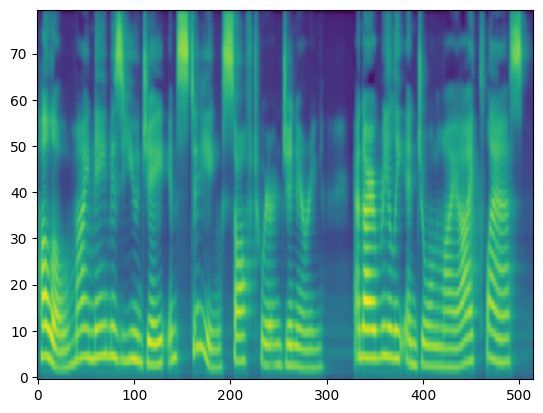

In [10]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

#text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 553])
torch.Size([80, 571])
torch.Size([80, 601])


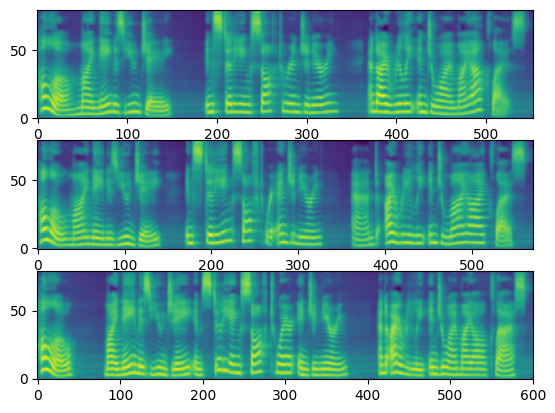

In [11]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [12]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

#text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


100%|██████████| 16.7M/16.7M [00:00<00:00, 214MB/s]


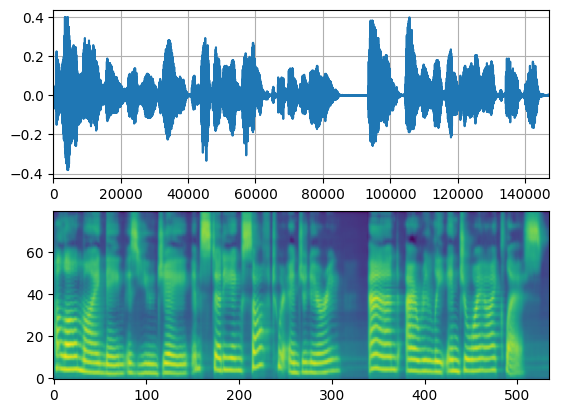

In [13]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [14]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:00<00:00, 314MB/s] 


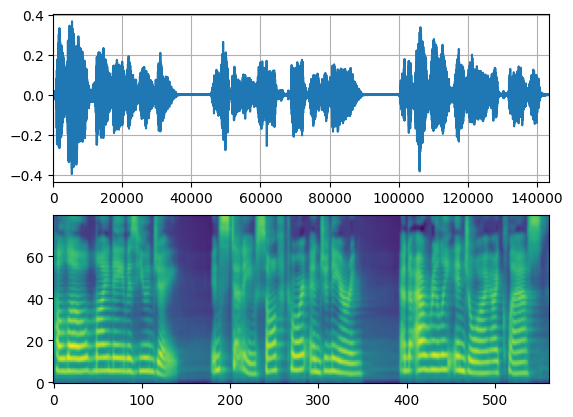

In [15]:
plot(waveforms, spec, vocoder.sample_rate)

In [16]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth" to /root/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190306.pth


###한국어 TTS 모델

fish


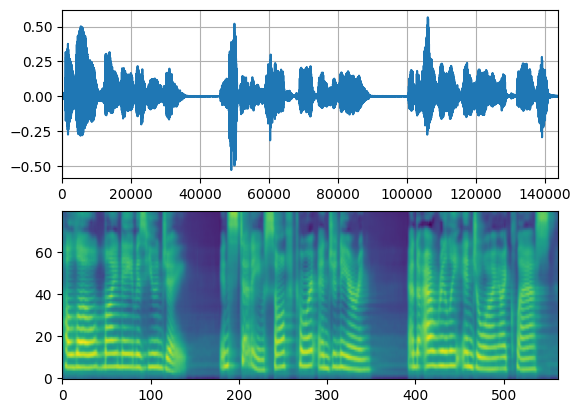

In [17]:
plot(waveforms, spec, 22050)